In [1]:
import pandas as pd

df = pd.read_parquet("/content/final_prepared_dataset.parquet")

print("Shape of dataset:", df.shape)
print("\nColumn names:\n", df.columns.tolist())
print("\nFirst few rows:")
#display(df.head())

print("\nClass distribution:")
print(df['label'].value_counts())

print("\nFamily distribution:")
print(df['family'].value_counts())


Shape of dataset: (194466, 26)

Column names:
 ['family', 'window_id', 'read_throughput', 'read_lba_var', 'write_throughput', 'write_lba_var', 'write_entropy', 'mem_read_count_4k', 'mem_read_count_2m', 'mem_read_count_mmio', 'mem_read_gpa_var', 'mem_write_entropy', 'mem_write_count_4k', 'mem_write_count_2m', 'mem_write_count_mmio', 'mem_write_gpa_var', 'mem_readwrite_entropy', 'mem_readwrite_count_4k', 'mem_readwrite_count_2m', 'mem_readwrite_count_mmio', 'mem_readwrite_gpa_var', 'mem_exec_count_4k', 'mem_exec_count_2m', 'mem_exec_count_mmio', 'mem_exec_gpa_var', 'label']

First few rows:

Class distribution:
label
0    101443
1     93023
Name: count, dtype: int64

Family distribution:
family
Firefox     20207
AESCrypt    19557
Zip         18295
LockBit     18093
Conti       17739
SDelete     17332
Darkside    16771
REvil       15296
WannaCry    14488
Office      13468
Idle        12584
Ryuk        10636
Name: count, dtype: int64


In [2]:
import numpy as np
from tqdm import tqdm
4
SEQUENCE_LENGTH = 40

df_sorted = df.sort_values(by=["family", "window_id"]).reset_index(drop=True)

feature_cols = [col for col in df.columns if col not in ["family", "window_id", "label"]]

sequences = []
sequence_labels = []
sequence_families = []

for family, group in tqdm(df_sorted.groupby("family")):

    group_features = group[feature_cols].values
    group_labels = group["label"].values

    for i in range(len(group) - SEQUENCE_LENGTH + 1):
        seq = group_features[i:i+SEQUENCE_LENGTH]
        label = group_labels[i+SEQUENCE_LENGTH - 1]

        sequences.append(seq)
        sequence_labels.append(label)
        sequence_families.append(family)

sequences = np.array(sequences)
sequence_labels = np.array(sequence_labels)
sequence_families = np.array(sequence_families)

print("Total sequences generated:", sequences.shape[0])
print("Shape of each sequence:", sequences.shape[1:])
print("Sequence labels distribution:")
unique, counts = np.unique(sequence_labels, return_counts=True)
print(dict(zip(unique, counts)))


100%|██████████| 12/12 [00:00<00:00, 65.99it/s]


Total sequences generated: 193998
Shape of each sequence: (40, 23)
Sequence labels distribution:
{np.int64(0): np.int64(101209), np.int64(1): np.int64(92789)}


In [3]:
from collections import Counter

family_aware_folds = {
    1: {
        "train_families": ['LockBit', 'WannaCry', 'Office', 'Zip', 'SDelete', 'AESCrypt'],
        "val_families": ['Firefox', 'Ryuk', 'Darkside']
    },
    2: {
        "train_families": ['Conti', 'Firefox', 'Idle', 'LockBit', 'REvil', 'Ryuk'],
        "val_families": ['Darkside', 'Office', 'Zip']
    },
    3: {
        "train_families": ['Darkside', 'Firefox', 'Office', 'REvil', 'Ryuk', 'Zip'],
        "val_families": ['Conti', 'LockBit', 'Idle']
    }
}

FOLD_NUMBER = 1

current_fold = family_aware_folds[FOLD_NUMBER]
train_families = current_fold["train_families"]
val_families = current_fold["val_families"]

test_families = ['Conti', 'Idle', 'REvil']

print(f"📌 Using Fold {FOLD_NUMBER}")
print("Train Families:", train_families)
print("Validation Families:", val_families)
print("Test Families:", test_families)


train_indices = []
val_indices = []
test_indices = []

for idx, family in enumerate(sequence_families):
    if family in train_families:
        train_indices.append(idx)
    elif family in val_families:
        val_indices.append(idx)
    elif family in test_families:
        test_indices.append(idx)

X_family_train = sequences[train_indices]
y_family_train = sequence_labels[train_indices]

X_family_val = sequences[val_indices]
y_family_val = sequence_labels[val_indices]

X_family_test = sequences[test_indices]
y_family_test = sequence_labels[test_indices]



def print_split(name, X, y, families):
    print(f"\n{name} → {X.shape[0]} sequences")
    counts = Counter(y)
    print(f"  - Benign: {counts[0]} sequences")
    print(f"  - Ransomware: {counts[1]} sequences")
    print(f"  Families: {families}")



📌 Using Fold 1
Train Families: ['LockBit', 'WannaCry', 'Office', 'Zip', 'SDelete', 'AESCrypt']
Validation Families: ['Firefox', 'Ryuk', 'Darkside']
Test Families: ['Conti', 'Idle', 'REvil']


In [4]:
print("📌 Family-Aware Split Summary\n")

print("Train (Seen Families):")
print_split("Train", X_family_train, y_family_train, train_families)

print("Validation (Unseen Families):")
print_split("Validation", X_family_val, y_family_val, val_families)

print("Test (Unseen Families):")
print_split("Test", X_family_test, y_family_test, test_families)


📌 Family-Aware Split Summary

Train (Seen Families):

Train → 100999 sequences
  - Benign: 68496 sequences
  - Ransomware: 32503 sequences
  Families: ['LockBit', 'WannaCry', 'Office', 'Zip', 'SDelete', 'AESCrypt']
Validation (Unseen Families):

Validation → 47497 sequences
  - Benign: 20168 sequences
  - Ransomware: 27329 sequences
  Families: ['Firefox', 'Ryuk', 'Darkside']
Test (Unseen Families):

Test → 45502 sequences
  - Benign: 12545 sequences
  - Ransomware: 32957 sequences
  Families: ['Conti', 'Idle', 'REvil']


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv1D, MaxPooling1D, LSTM, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

SEQ_LEN = 40
NUM_FEATURES = 23

model = Sequential([
    InputLayer(input_shape=(SEQ_LEN, NUM_FEATURES)),           # (40, 23)
    Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=l2(0.001)),      # Conv1D over time
    MaxPooling1D(pool_size=2),                                 # Downsample to length ~20
    LSTM(256, return_sequences=True),                          # First LSTM layer
    #Dropout(0.3),
    LSTM(256, return_sequences=False),                         # Second LSTM, output final state
    #Dropout(0.3),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))                             # Binary output
])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 36, 64)         │         7,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 18, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 18, 256)        │       328,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 861,697 (3.29 MB)

 Trainable params: 861,697 (3.29 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from tensorflow.keras.metrics import BinaryAccuracy, CategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# ─── Compiling the Model ───
model.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(learning_rate=0.0001),
    metrics=[
        BinaryAccuracy(name='accuracy'),
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

# ─── Callbacks ───
checkpoint_path = "cnn_lstm_best_weights.h5"
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
callbacks.append(lr_schedule)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_family_train),
    y=y_family_train
)

class_weight_dict = dict(enumerate(class_weights))


In [ ]:
print("Original y shape:", y_family_train.shape)
print("Unique labels:", np.unique(y_family_train))
from tensorflow.keras.utils import to_categorical
y_family_train = to_categorical(y_family_train, num_classes=2)
y_family_val = to_categorical(y_family_val, num_classes=2)
print("Original y shape:", y_family_train.shape)
print("Unique labels:", np.unique(y_family_train))

Original y shape: (100999,)
Unique labels: [0 1]
Original y shape: (100999, 2)
Unique labels: [0. 1.]


In [ ]:
# ─── Train on Family-Aware Split ───
history = model.fit(
    X_family_train, y_family_train,
    validation_data=(X_family_val, y_family_val),
    epochs=50,
    batch_size=128,
    callbacks=callbacks,
    #shuffle=False,
    class_weight=class_weight_dict,  # 👈 Add this line
    verbose=1
)

Epoch 1/50
790/790 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.7596 - loss: 0.4644 - precision: 0.5987 - recall: 0.8511  
Epoch 1: val_loss improved from inf to 0.81016, saving model to cnn_lstm_best_weights.h5


790/790 ━━━━━━━━━━━━━━━━━━━━ 168s 205ms/step - accuracy: 0.7596 - loss: 0.4643 - precision: 0.5988 - recall: 0.8511 - val_accuracy: 0.6249 - val_loss: 0.8102 - val_precision: 0.7408 - val_recall: 0.5354 - learning_rate: 1.0000e-04
Epoch 2/50
789/790 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8490 - loss: 0.3302 - precision: 0.7142 - recall: 0.8783  
Epoch 2: val_loss did not improve from 0.81016
790/790 ━━━━━━━━━━━━━━━━━━━━ 146s 184ms/step - accuracy: 0.8490 - loss: 0.3302 - precision: 0.7142 - recall: 0.8783 - val_accuracy: 0.6236 - val_loss: 0.8466 - val_precision: 0.7289 - val_recall: 0.5507 - learning_rate: 1.0000e-04
Epoch 3/50
789/790 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8471 - loss: 0.3269 - precision: 0.7119 - recall: 0.8811  
Epoch 3: val_loss did not improve from 0.81016
790/790 ━━━━━━━━━━━━━━━━━━━━ 140s 177ms/step - accuracy: 0.8471 - loss: 0.3269 - precision: 0.7119 - recall: 0.8811 - val_accuracy: 0.6175 - val_loss: 0.9008 - val_precision: 0.7272 - val_re

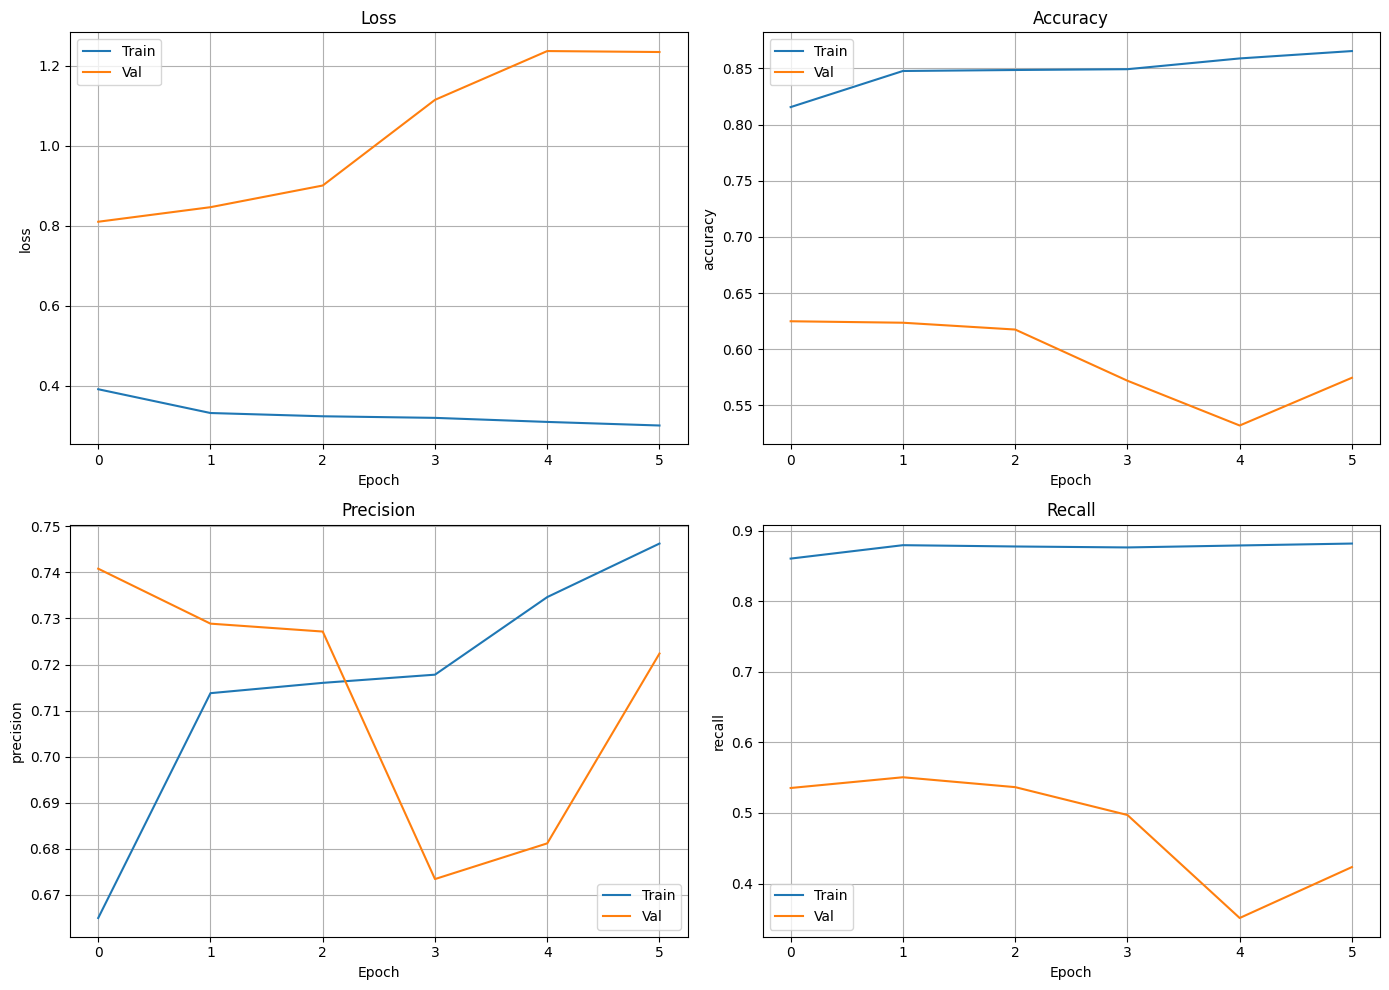

In [ ]:
# ─── Plot Training Curves ───
def plot_metrics(history):
    metrics = ['loss', 'accuracy', 'precision', 'recall']
    plt.figure(figsize=(14, 10))
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        plt.plot(history.history[metric], label='Train')
        plt.plot(history.history[f'val_{metric}'], label='Val')
        plt.title(metric.capitalize())
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.grid(True)
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_metrics(history)

1422/1422 ━━━━━━━━━━━━━━━━━━━━ 51s 36ms/step
📊 Classification Report:
              precision    recall  f1-score   support

           0     0.7199    0.8380    0.7745     12545
           1     0.9342    0.8759    0.9041     32957

    accuracy                         0.8655     45502
   macro avg     0.8271    0.8570    0.8393     45502
weighted avg     0.8751    0.8655    0.8684     45502

F1-score (manual): 0.9041


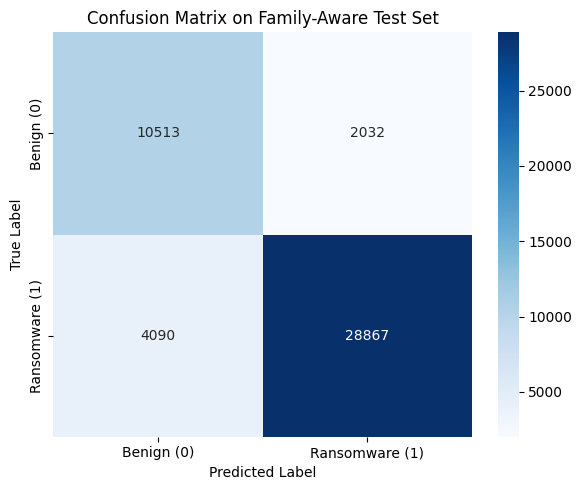

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ─── Predict on Test Set ───
y_pred_probs = model.predict(X_family_test)
y_pred = (y_pred_probs >= 0.3).astype(int).flatten()
#y_pred = np.argmax(y_pred_probs, axis=1)

# ─── Evaluation Report ───
print("📊 Classification Report:")
print(classification_report(y_family_test, y_pred, digits=4))

# ─── F1 Score (Optional Manual) ───
f1 = f1_score(y_family_test, y_pred)
print(f"F1-score (manual): {f1:.4f}")

# ─── Confusion Matrix ───
cm = confusion_matrix(y_family_test, y_pred)
labels = ['Benign (0)', 'Ransomware (1)']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix on Family-Aware Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Concatenate
from tensorflow.keras.regularizers import l2

SEQ_LEN = 40
NUM_FEATURES = 23

# Input
inp = Input(shape=(SEQ_LEN, NUM_FEATURES))

# ── Branch 1: Depthwise Conv + MaxPool + LSTM
x1 = Conv1D(filters=23, kernel_size=3, groups=23, activation='relu',
            kernel_regularizer=l2(0.001))(inp)
#x1 = MaxPooling1D(pool_size=2)(x1)
lstm1 = LSTM(256, return_sequences=True)(x1)
lstm1 = LSTM(256, return_sequences=False)(lstm1)

# ── Branch 2: Unified Conv + MaxPool + LSTM
x2 = Conv1D(filters=64, kernel_size=3, activation='relu',
            kernel_regularizer=l2(0.001))(inp)
#x2 = MaxPooling1D(pool_size=2)(x2)
lstm2 = LSTM(256, return_sequences=True)(x2)
lstm2 = LSTM(256, return_sequences=False)(lstm2)

# ── Fusion
fused = Concatenate()([lstm1, lstm2])
output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))(fused)

# ── Final model
dual_model = Model(inputs=inp, outputs=output)
dual_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 40, 23)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 38, 23)    │         92 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 38, 64)    │      4,480 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 38, 256)   │    286,720 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 38, 256)   │    328,704 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 256)       │    525,312 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 256)       │    525,312 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        513 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,671,133 (6.37 MB)

 Trainable params: 1,671,133 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

dual_model.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(learning_rate=0.0001),  # Lower LR as per previous wins
    metrics=[
        BinaryAccuracy(name='accuracy'),
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

checkpoint_path = "depthwise_lstm_best.h5"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
]


In [8]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_family_train),
    y=y_family_train
)

class_weight_dict = dict(enumerate(class_weights))


In [9]:
history = dual_model.fit(
    X_family_train, y_family_train,
    validation_data=(X_family_val, y_family_val),
    epochs=50,
    batch_size=128,
    callbacks=callbacks,
    shuffle=True,
    class_weight=class_weight_dict,
    verbose=1
)


Epoch 1/50
790/790 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8679 - loss: 0.3077 - precision: 0.7536 - recall: 0.9078
Epoch 1: val_loss improved from inf to 0.94965, saving model to depthwise_lstm_best.h5


790/790 ━━━━━━━━━━━━━━━━━━━━ 36s 35ms/step - accuracy: 0.8680 - loss: 0.3076 - precision: 0.7536 - recall: 0.9078 - val_accuracy: 0.6784 - val_loss: 0.9496 - val_precision: 0.8548 - val_recall: 0.5314
Epoch 2/50
788/790 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9362 - loss: 0.1651 - precision: 0.8687 - recall: 0.9451
Epoch 2: val_loss did not improve from 0.94965
790/790 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - accuracy: 0.9362 - loss: 0.1651 - precision: 0.8688 - recall: 0.9451 - val_accuracy: 0.7028 - val_loss: 0.9539 - val_precision: 0.8469 - val_recall: 0.5903
Epoch 3/50
789/790 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9512 - loss: 0.1236 - precision: 0.8971 - recall: 0.9573
Epoch 3: val_loss improved from 0.94965 to 0.68324, saving model to depthwise_lstm_best.h5


790/790 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.9512 - loss: 0.1236 - precision: 0.8971 - recall: 0.9573 - val_accuracy: 0.7786 - val_loss: 0.6832 - val_precision: 0.8610 - val_recall: 0.7337
Epoch 4/50
789/790 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9568 - loss: 0.1118 - precision: 0.9072 - recall: 0.9645
Epoch 4: val_loss did not improve from 0.68324
790/790 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.9568 - loss: 0.1118 - precision: 0.9072 - recall: 0.9645 - val_accuracy: 0.7623 - val_loss: 0.7816 - val_precision: 0.8562 - val_recall: 0.7055
Epoch 5/50
789/790 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9641 - loss: 0.0951 - precision: 0.9213 - recall: 0.9717
Epoch 5: val_loss did not improve from 0.68324
790/790 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.9641 - loss: 0.0951 - precision: 0.9213 - recall: 0.9717 - val_accuracy: 0.7570 - val_loss: 0.8877 - val_precision: 0.8393 - val_recall: 0.7146
Epoch 6/50
789/790 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - 

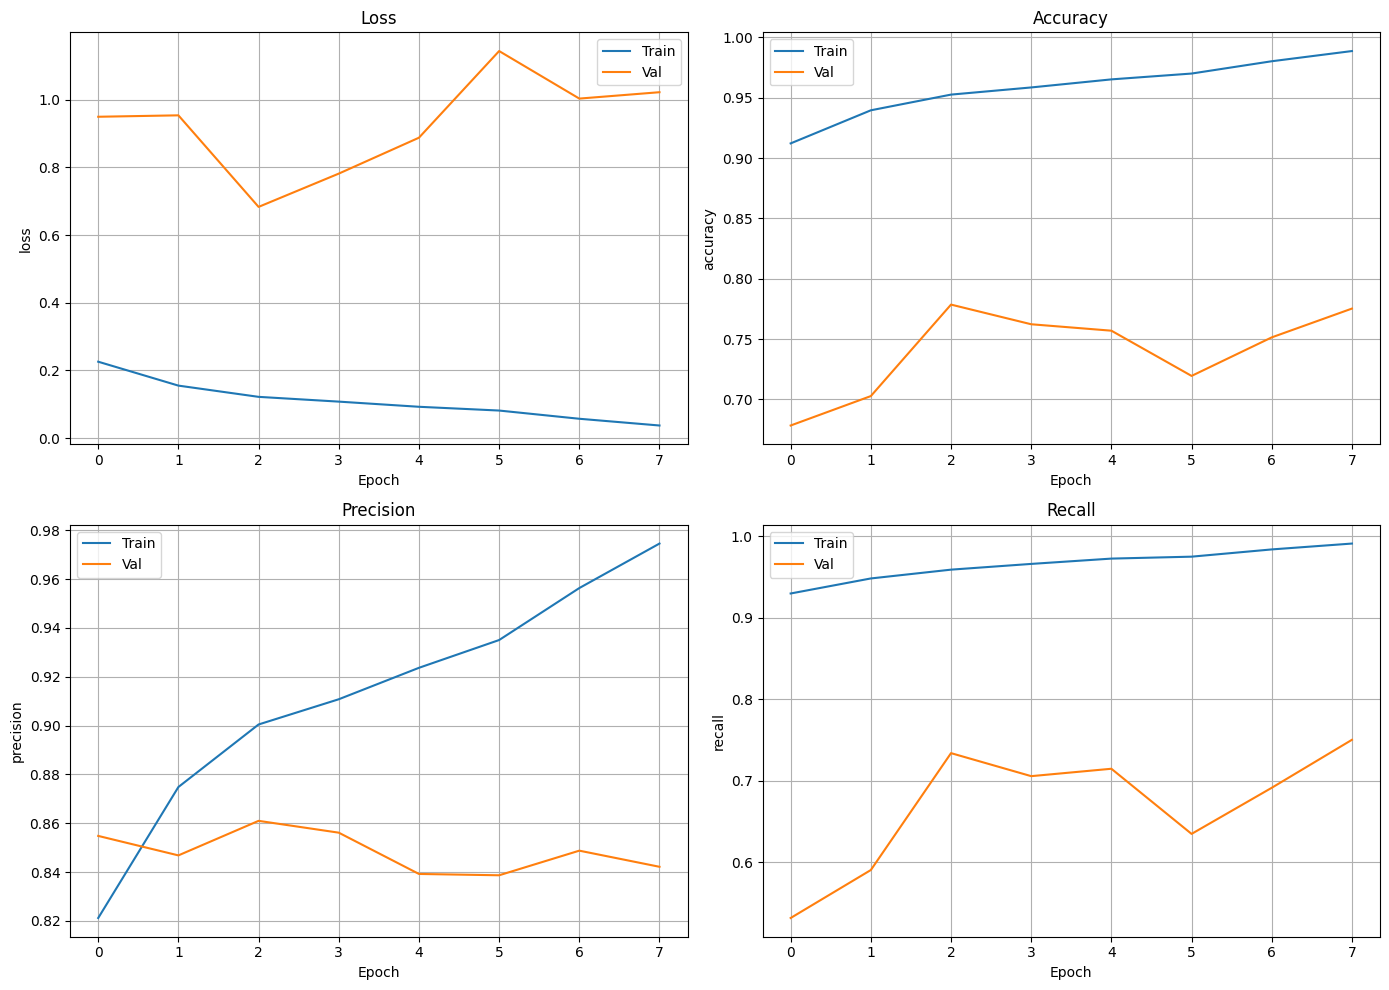

In [10]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    metrics = ['loss', 'accuracy', 'precision', 'recall']
    plt.figure(figsize=(14, 10))
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        plt.plot(history.history[metric], label='Train')
        plt.plot(history.history[f'val_{metric}'], label='Val')
        plt.title(metric.capitalize())
        plt.xlabel("Epoch")
        plt.ylabel(metric)
        plt.grid(True)
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_metrics(history)


1422/1422 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
📊 Classification Report:
              precision    recall  f1-score   support

           0     0.7014    0.8747    0.7785     12545
           1     0.9473    0.8582    0.9006     32957

    accuracy                         0.8628     45502
   macro avg     0.8244    0.8665    0.8395     45502
weighted avg     0.8795    0.8628    0.8669     45502

F1-score (manual): 0.9006


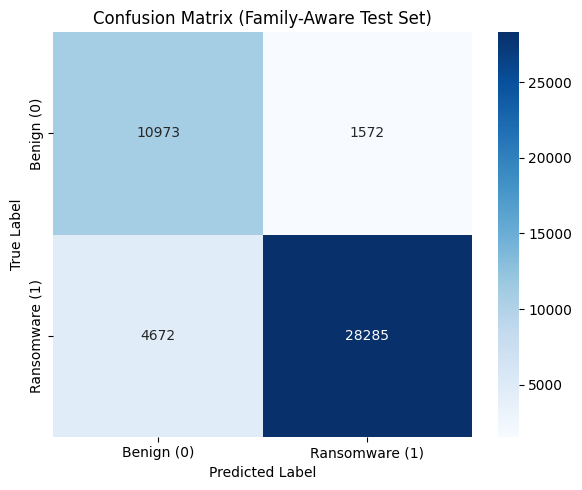

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import numpy as np

# Predict with threshold = 0.3
y_probs = dual_model.predict(X_family_test)
y_pred = (y_probs >= 0.3).astype(int).flatten()

# Classification Report
print("📊 Classification Report:")
print(classification_report(y_family_test, y_pred, digits=4))

# F1-score
print("F1-score (manual):", round(f1_score(y_family_test, y_pred), 4))

# Confusion Matrix
cm = confusion_matrix(y_family_test, y_pred)
labels = ['Benign (0)', 'Ransomware (1)']
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (Family-Aware Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
